# Restaurant Data Analysis

This notebook performs comprehensive analysis on restaurant data from a CSV file. We'll explore various aspects of the restaurant data including prices, ratings, food types, and menu items to extract meaningful insights.

## Import Required Libraries

First, we'll import the necessary Python libraries for data manipulation, visualization, and numerical operations.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display

# Set visualization style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# For better display in notebook
pd.set_option('display.max_columns', None)

Matplotlib is building the font cache; this may take a moment.


## Load and Explore the Dataset

Let's load the restaurant data from the CSV file and perform initial exploration to understand its structure.

In [4]:
# Load the dataset
file_path = '../data/processed/restaurant_data.csv'
df = pd.read_csv(file_path)

# Display first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Get basic information about the dataframe
print("\nDataset information:")
df.info()

# Check for missing values
print("\nMissing values in each column:")
display(df.isna().sum())

# Get basic statistics
print("\nBasic statistics of the dataset:")
display(df.describe().T)

# Check the shape of the dataset
print(f"\nDataset shape: {df.shape} (rows, columns)")

# Get unique restaurant names
print(f"\nNumber of unique restaurants: {df['name'].nunique()}")
print(f"\nList of restaurants:")
for restaurant in df['name'].unique():
    print(f"- {restaurant}")

First 5 rows of the dataset:


,id,name,location,menu_0_name,menu_0_description,menu_0_price,menu_0_rating,menu_0_food_type,menu_1_name,menu_1_description,menu_1_price,menu_1_rating,menu_1_food_type,menu_2_name,menu_2_description,menu_2_price,menu_2_rating,menu_2_food_type,special_features,contact_info,url
0,591b5de0-bc69-4fe0-b287-9517a1b8b048,Behrouz Biryani Royal Biryani Online in Gomti ...,"Gomti Nagar, Lucknow",Lazeez Bhuna Murgh Biryani (Dum Chicken Biryan...,"(Boneless, Served with 1 Gulab Jamun & Mint Ra...",399.0,4.4,Non-Vegetarian,"Dum Gosht Biryani (Dum Mutton Biryani, Boneles...","(Boneless, Served with 1 Gulab Jamun & Mint Ra...",569.0,4.3,Non-Vegetarian,Murgh Afghani Tikka Biryani (Creamy Chicken Ti...,"(Boneless, Served with 1 Gulab Jamun & Mint Ra...",465.0,4.4,Non-Vegetarian,"Vegetarian options available, Outdoor seating",7304047007,https://www.eatsure.com/behrouz-biryani/luckno...
1,90fc29ce-cfa7-489a-9b9c-c3963946c5fe,"The Good Bowl Rice Bowl Online in Gomti Nagar,...","Gomti Nagar, Lucknow",Chicken Tikka Masala Rice Bowl,"(450 gms) Smoky, juicy peices of chicken is th...",389.0,4.4,Non-Vegetarian,Chicken Lababdar Rice Bowl,(450 gms) Boneless chicken in creamy tomato gr...,389.0,4.4,Non-Vegetarian,Palak Paneer Rice Bowl,(450 gms) Soft paneer cubes cooked in velverty...,309.0,4.4,Vegetarian,"Vegetarian options available, Outdoor seating",7304047007,https://www.eatsure.com/the-good-bowl/lucknow/...
2,ee37ae19-de81-4de8-bb17-0d889c089c08,Biryani Blues Biryani & Kebab Online in Gomti ...,"Gomti Nagar, Lucknow",Pepper Chicken,NaN,129.0,NaN,Non-Vegetarian,Pepper Chicken Biryani,NaN,199.0,3.9,Non-Vegetarian,Pepper Paneer Biryani,NaN,199.0,4.3,Vegetarian,Traditional dining experience,7304047007,https://www.eatsure.com/biryani-blues/lucknow/...
3,68d940ea-9f16-4d7a-8258-a9ce33f7bd5d,"Ovenstory Pizza Online in Gomti Nagar, Lucknow","Gomti Nagar, Lucknow",Double Cheese Tandoori Paneer Tikka Medium Pizza,Now with twice the cheesy goodness - Your pizz...,539.0,NaN,Vegetarian,Double Cheese Dragonfire Margherita Medium Pizza,Now with twice the cheesy goodness - Your marg...,439.0,NaN,Vegetarian,Double Cheese Garden Fresh Veggie Medium Pizza,Now with twice the cheesy goodness - Your pizz...,525.0,4.1,Vegetarian,Traditional dining experience,7304047007,https://www.eatsure.com/ovenstory/lucknow/gomt...
4,67a5e308-8b35-4b4b-b626-4a98618421df,"Honest bowl Rice Bowls Online in Gomti Nagar, ...","Gomti Nagar, Lucknow",1 + 1 classic bowl combo (Veg),NaN,NaN,4.3,Vegetarian,1 + 1 classic bowl combo (Non-Veg),NaN,NaN,4.2,Non-Vegetarian,1 + 1 signature bowl combo (Veg),NaN,NaN,3.8,Vegetarian,Traditional dining experience,7304047007,https://www.eatsure.com/honest-bowl/lucknow/go...



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10 non-null     object 
 1   name                10 non-null     object 
 2   location            10 non-null     object 
 3   menu_0_name         10 non-null     object 
 4   menu_0_description  8 non-null      object 
 5   menu_0_price        9 non-null      object 
 6   menu_0_rating       6 non-null      float64
 7   menu_0_food_type    10 non-null     object 
 8   menu_1_name         9 non-null      object 
 9   menu_1_description  7 non-null      object 
 10  menu_1_price        7 non-null      float64
 11  menu_1_rating       8 non-null      float64
 12  menu_1_food_type    9 non-null      object 
 13  menu_2_name         8 non-null      object 
 14  menu_2_description  6 non-null      object 
 15  menu_2_price        7 non-null      fl

id                    0
name                  0
location              0
menu_0_name           0
menu_0_description    2
menu_0_price          1
menu_0_rating         4
menu_0_food_type      0
menu_1_name           1
menu_1_description    3
menu_1_price          3
menu_1_rating         2
menu_1_food_type      1
menu_2_name           2
menu_2_description    4
menu_2_price          3
menu_2_rating         2
menu_2_food_type      2
special_features      0
contact_info          0
url                   0
dtype: int64


Basic statistics of the dataset:


,count,mean,std,min,25%,50%,75%,max
menu_0_rating,6.0,4.283333e+00,0.194079,3.900000e+00,4.300000e+00,4.350000e+00,4.400000e+00,4.400000e+00
menu_1_price,7.0,3.140000e+02,162.608938,8.400000e+01,2.240000e+02,2.690000e+02,4.140000e+02,5.690000e+02
menu_1_rating,8.0,4.287500e+00,0.180772,3.900000e+00,4.275000e+00,4.300000e+00,4.400000e+00,4.500000e+00
menu_2_price,7.0,3.250000e+02,123.423391,1.990000e+02,2.390000e+02,2.990000e+02,3.870000e+02,5.250000e+02
menu_2_rating,8.0,4.212500e+00,0.203101,3.800000e+00,4.100000e+00,4.300000e+00,4.325000e+00,4.400000e+00
contact_info,10.0,7.304047e+09,0.000000,7.304047e+09,7.304047e+09,7.304047e+09,7.304047e+09,7.304047e+09



Dataset shape: (10, 21) (rows, columns)

Number of unique restaurants: 10

List of restaurants:
- Behrouz Biryani Royal Biryani Online in Gomti Nagar, Lucknow
- The Good Bowl Rice Bowl Online in Gomti Nagar, Lucknow
- Biryani Blues Biryani & Kebab Online in Gomti Nagar, Lucknow
- Ovenstory Pizza Online in Gomti Nagar, Lucknow
- Honest bowl Rice Bowls Online in Gomti Nagar, Lucknow
- Lunchbox - Meals & Thalis Homely Meals Online in Gomti Nagar, Lucknow
- Slow Churn Ice Cream Online in Gomti Nagar, Lucknow
- Kwality Walls Dessert and Ice Cream Frozen Desserts and Ice Cream Online in Gomti Nagar, Lucknow
- Thalaiva Biryani Online in Gomti Nagar, Lucknow
- Firangi Bake Pasta & Lasagnas Online in Gomti Nagar, Lucknow


## Data Cleaning and Preprocessing

Now, let's clean the dataset by handling missing values, converting data types (especially price columns to numeric), and creating additional features if needed.

In [5]:
# Function to convert price columns to numeric
def convert_to_numeric(x):
    if pd.isna(x):
        return np.nan
    elif isinstance(x, str) and x.strip() == '':
        return np.nan
    else:
        try:
            return float(x)
        except:
            return np.nan

# Identify price columns
price_columns = [col for col in df.columns if 'price' in col]
print("Price columns:", price_columns)

# Convert price columns to numeric
for col in price_columns:
    df[col] = df[col].apply(convert_to_numeric)

# Similarly, convert rating columns to numeric
rating_columns = [col for col in df.columns if 'rating' in col]
print("Rating columns:", rating_columns)

for col in rating_columns:
    df[col] = df[col].apply(convert_to_numeric)

# Create a consolidated menu items dataframe for easier analysis
menu_items = pd.DataFrame()

# Loop through each menu item (up to 3 items per restaurant)
for i in range(3):
    temp_df = df[['id', 'name', 'location', f'menu_{i}_name', f'menu_{i}_description', 
                  f'menu_{i}_price', f'menu_{i}_rating', f'menu_{i}_food_type']].copy()
    
    # Rename columns
    temp_df.columns = ['restaurant_id', 'restaurant_name', 'location', 'item_name', 
                        'item_description', 'price', 'rating', 'food_type']
    
    # Filter out rows where item name is missing
    temp_df = temp_df.dropna(subset=['item_name'])
    
    # Add to consolidated dataframe
    menu_items = pd.concat([menu_items, temp_df], ignore_index=True)

# Display the first few rows of the consolidated menu items dataframe
print("\nFirst 5 rows of consolidated menu items:")
display(menu_items.head())

# Check the shape of the consolidated dataframe
print(f"\nConsolidated menu items shape: {menu_items.shape} (rows, columns)")

# Create price categories for easier analysis
def categorize_price(price):
    if pd.isna(price):
        return np.nan
    elif price < 200:
        return 'Budget'
    elif price < 350:
        return 'Mid-range'
    else:
        return 'Premium'

menu_items['price_category'] = menu_items['price'].apply(categorize_price)

# Check the distribution of price categories
print("\nDistribution of price categories:")
display(menu_items['price_category'].value_counts(dropna=False))

Price columns: ['menu_0_price', 'menu_1_price', 'menu_2_price']
Rating columns: ['menu_0_rating', 'menu_1_rating', 'menu_2_rating']

First 5 rows of consolidated menu items:


,restaurant_id,restaurant_name,location,item_name,item_description,price,rating,food_type
0,591b5de0-bc69-4fe0-b287-9517a1b8b048,Behrouz Biryani Royal Biryani Online in Gomti ...,"Gomti Nagar, Lucknow",Lazeez Bhuna Murgh Biryani (Dum Chicken Biryan...,"(Boneless, Served with 1 Gulab Jamun & Mint Ra...",399.0,4.4,Non-Vegetarian
1,90fc29ce-cfa7-489a-9b9c-c3963946c5fe,"The Good Bowl Rice Bowl Online in Gomti Nagar,...","Gomti Nagar, Lucknow",Chicken Tikka Masala Rice Bowl,"(450 gms) Smoky, juicy peices of chicken is th...",389.0,4.4,Non-Vegetarian
2,ee37ae19-de81-4de8-bb17-0d889c089c08,Biryani Blues Biryani & Kebab Online in Gomti ...,"Gomti Nagar, Lucknow",Pepper Chicken,NaN,129.0,NaN,Non-Vegetarian
3,68d940ea-9f16-4d7a-8258-a9ce33f7bd5d,"Ovenstory Pizza Online in Gomti Nagar, Lucknow","Gomti Nagar, Lucknow",Double Cheese Tandoori Paneer Tikka Medium Pizza,Now with twice the cheesy goodness - Your pizz...,539.0,NaN,Vegetarian
4,67a5e308-8b35-4b4b-b626-4a98618421df,"Honest bowl Rice Bowls Online in Gomti Nagar, ...","Gomti Nagar, Lucknow",1 + 1 classic bowl combo (Veg),NaN,NaN,4.3,Vegetarian



Consolidated menu items shape: (27, 8) (rows, columns)

Distribution of price categories:


price_category
Premium      9
Mid-range    9
NaN          5
Budget       4
Name: count, dtype: int64

## Basic Statistical Analysis

Let's calculate descriptive statistics for numerical columns (prices, ratings), including mean, median, standard deviation, min/max values and summarize key findings.

In [6]:
# Basic statistics for menu items
print("Basic statistics for menu items:")
stats_df = menu_items[['price', 'rating']].describe()
display(stats_df)

# Mean, median and standard deviation of prices by food type
print("\nPrice statistics by food type:")
food_type_stats = menu_items.groupby('food_type')['price'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
display(food_type_stats)

# Mean, median and standard deviation of ratings by food type
print("\nRating statistics by food type:")
rating_stats = menu_items.groupby('food_type')['rating'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
display(rating_stats)

# Restaurant-level statistics
restaurant_stats = menu_items.groupby('restaurant_name').agg(
    avg_price=('price', 'mean'),
    avg_rating=('rating', 'mean'),
    num_items=('item_name', 'count')
).sort_values('avg_rating', ascending=False)

print("\nRestaurant statistics:")
display(restaurant_stats)

# Summary of key findings
print("\nKey statistical findings:")
print(f"- Average price across all menu items: ₹{menu_items['price'].mean():.2f}")
print(f"- Average rating across all menu items: {menu_items['rating'].mean():.2f}/5.0")
print(f"- Most expensive item costs ₹{menu_items['price'].max():.2f}")
print(f"- Restaurant with highest average rating: {restaurant_stats.iloc[0].name} ({restaurant_stats['avg_rating'].iloc[0]:.2f}/5.0)")

Basic statistics for menu items:


,price,rating
count,22.000000,22.000000
mean,321.818182,4.259091
std,132.060461,0.186851
min,84.000000,3.800000
25%,234.000000,4.225000
50%,304.000000,4.300000
75%,396.500000,4.400000
max,569.000000,4.500000



Price statistics by food type:


,count,mean,median,std,min,max
food_type,,,,,,
Non-Vegetarian,10,341.200000,382.0,132.716741,129.0,569.0
Not specified,0,NaN,NaN,NaN,NaN,NaN
Vegetarian,12,305.666667,284.0,135.119027,84.0,539.0



Rating statistics by food type:


,count,mean,median,std,min,max
food_type,,,,,,
Non-Vegetarian,9,4.277778,4.4,0.178730,3.9,4.4
Not specified,0,NaN,NaN,NaN,NaN,NaN
Vegetarian,13,4.246154,4.3,0.198391,3.8,4.5



Restaurant statistics:


,avg_price,avg_rating,num_items
restaurant_name,,,
"The Good Bowl Rice Bowl Online in Gomti Nagar, Lucknow",362.333333,4.400000,3
"Behrouz Biryani Royal Biryani Online in Gomti Nagar, Lucknow",477.666667,4.366667,3
"Lunchbox - Meals & Thalis Homely Meals Online in Gomti Nagar, Lucknow",219.000000,4.366667,3
"Firangi Bake Pasta & Lasagnas Online in Gomti Nagar, Lucknow",314.333333,4.333333,3
"Thalaiva Biryani Online in Gomti Nagar, Lucknow",249.000000,4.200000,3
"Slow Churn Ice Cream Online in Gomti Nagar, Lucknow",201.000000,4.150000,2
"Honest bowl Rice Bowls Online in Gomti Nagar, Lucknow",NaN,4.100000,3
"Biryani Blues Biryani & Kebab Online in Gomti Nagar, Lucknow",175.666667,4.100000,3
"Ovenstory Pizza Online in Gomti Nagar, Lucknow",501.000000,4.100000,3



Key statistical findings:
- Average price across all menu items: ₹321.82
- Average rating across all menu items: 4.26/5.0
- Most expensive item costs ₹569.00
- Restaurant with highest average rating: The Good Bowl Rice Bowl Online in Gomti Nagar, Lucknow (4.40/5.0)


## Price Analysis

Let's analyze price distributions across different restaurants and food types, calculate average prices, identify price ranges, and determine if there are price differences between vegetarian and non-vegetarian items.

/Users/prashantyadav/Documents/FOSS/Restaurant-Rcraper-Rag-Bot/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


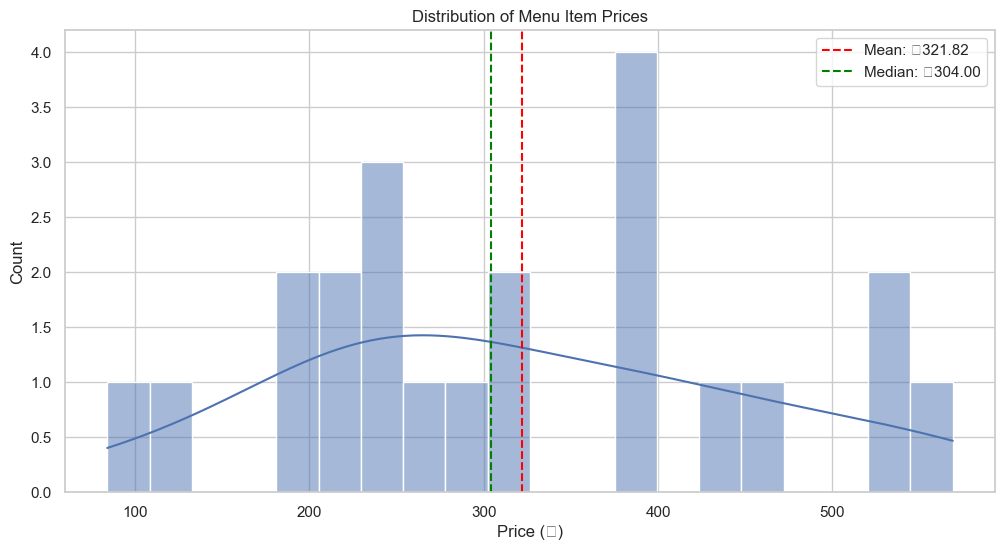

/Users/prashantyadav/Documents/FOSS/Restaurant-Rcraper-Rag-Bot/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


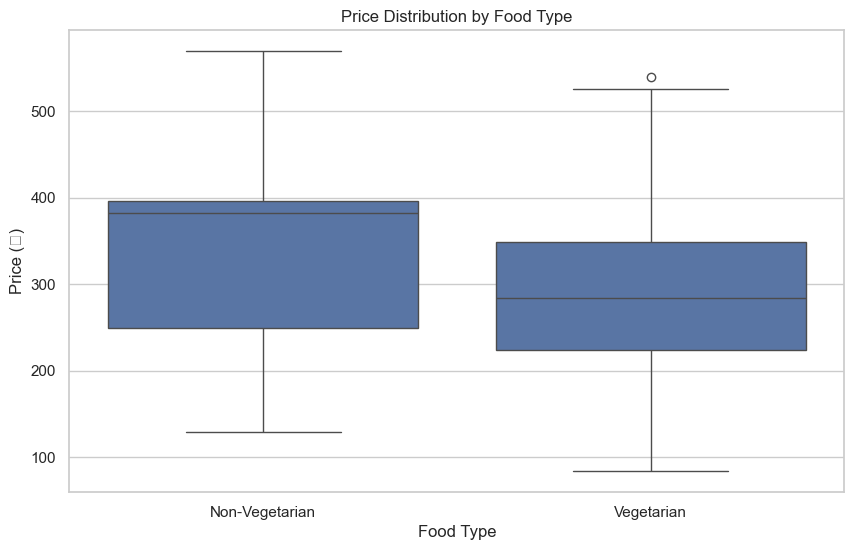

Price comparison between vegetarian and non-vegetarian items:
Vegetarian items average price: ₹305.67
Non-vegetarian items average price: ₹341.20
Price difference: ₹35.53
T-test p-value: 0.5424
The price difference is not statistically significant at 5% level.


/var/folders/xx/t1xs17xj5gv_pjb6hgdfmnqr0000gn/T/ipykernel_54474/3080558098.py:43: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/prashantyadav/Documents/FOSS/Restaurant-Rcraper-Rag-Bot/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


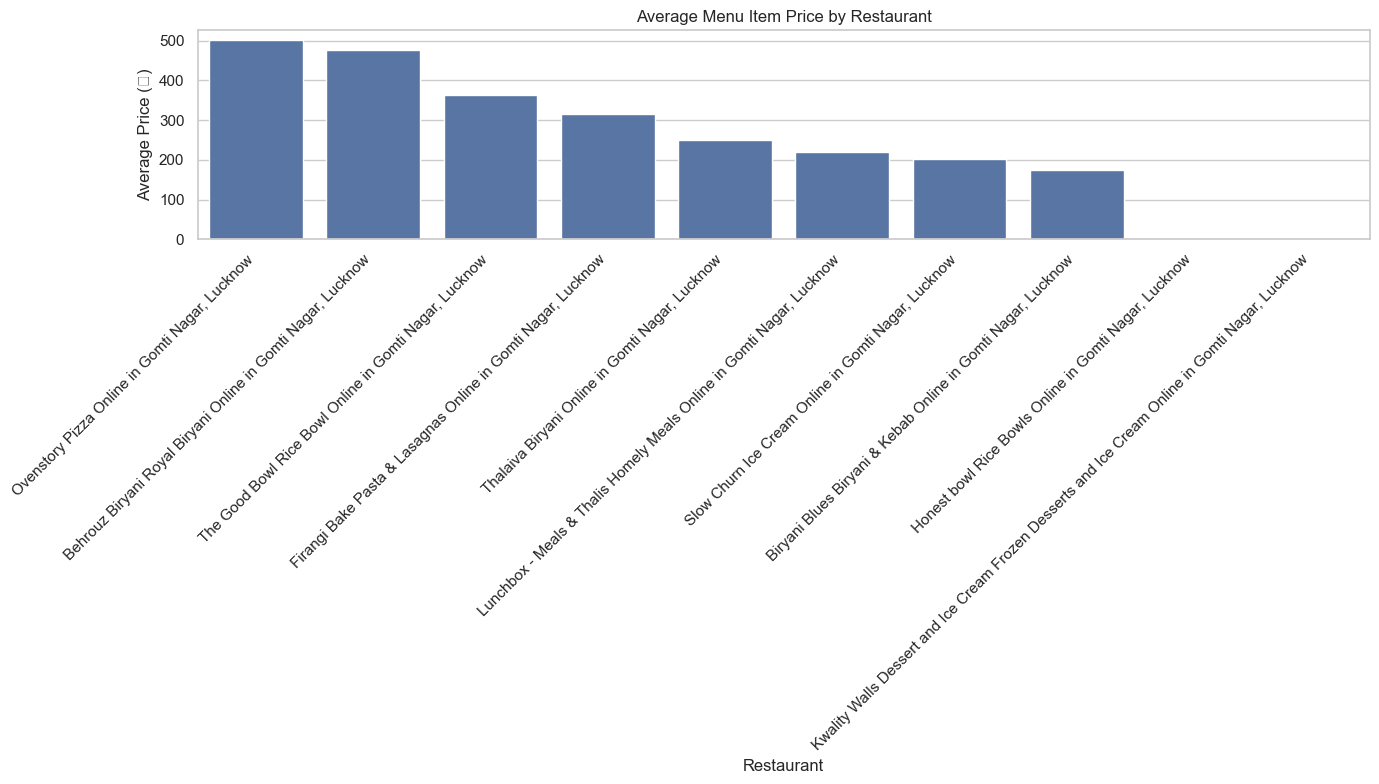

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [7]:
# Histogram of menu item prices
plt.figure(figsize=(12, 6))
sns.histplot(data=menu_items, x='price', bins=20, kde=True)
plt.title('Distribution of Menu Item Prices')
plt.xlabel('Price (₹)')
plt.ylabel('Count')
plt.axvline(menu_items['price'].mean(), color='red', linestyle='--', label=f'Mean: ₹{menu_items["price"].mean():.2f}')
plt.axvline(menu_items['price'].median(), color='green', linestyle='--', label=f'Median: ₹{menu_items["price"].median():.2f}')
plt.legend()
plt.show()

# Boxplot of prices by food type
plt.figure(figsize=(10, 6))
sns.boxplot(x='food_type', y='price', data=menu_items.dropna(subset=['food_type', 'price']))
plt.title('Price Distribution by Food Type')
plt.xlabel('Food Type')
plt.ylabel('Price (₹)')
plt.show()

# Compare prices between vegetarian and non-vegetarian items
veg_items = menu_items[menu_items['food_type'] == 'Vegetarian']['price']
nonveg_items = menu_items[menu_items['food_type'] == 'Non-Vegetarian']['price']

print("Price comparison between vegetarian and non-vegetarian items:")
print(f"Vegetarian items average price: ₹{veg_items.mean():.2f}")
print(f"Non-vegetarian items average price: ₹{nonveg_items.mean():.2f}")
print(f"Price difference: ₹{nonveg_items.mean() - veg_items.mean():.2f}")

# Statistical test to see if the difference is significant
from scipy import stats
t_stat, p_value = stats.ttest_ind(veg_items.dropna(), nonveg_items.dropna(), equal_var=False)
print(f"T-test p-value: {p_value:.4f}")
print(f"The price difference is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at 5% level.")

# Bar chart of average prices by restaurant
plt.figure(figsize=(14, 8))
restaurant_avg_prices = menu_items.groupby('restaurant_name')['price'].mean().sort_values(ascending=False)
sns.barplot(x=restaurant_avg_prices.index, y=restaurant_avg_prices.values)
plt.title('Average Menu Item Price by Restaurant')
plt.xlabel('Restaurant')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Price category distribution by restaurant
price_cat_by_restaurant = pd.crosstab(
    menu_items['restaurant_name'], 
    menu_items['price_category'], 
    normalize='index'
).reset_index()

# Melting the dataframe for easier plotting
price_cat_melted = price_cat_by_restaurant.melt(
    id_vars='restaurant_name', 
    var_name='Price Category', 
    value_name='Proportion'
)

# Create the stacked bar chart using plotly
fig = px.bar(
    price_cat_melted, 
    x='restaurant_name', 
    y='Proportion', 
    color='Price Category',
    title='Price Category Distribution by Restaurant',
    labels={'restaurant_name': 'Restaurant', 'Proportion': 'Proportion of Menu Items'},
)

fig.update_layout(
    xaxis_tickangle=-45,
    barmode='stack',
    height=500,
    width=900
)

fig.show()

## Rating Analysis

Let's examine the distribution of ratings, calculate average ratings by restaurant and food type, and identify top-rated menu items and restaurants.

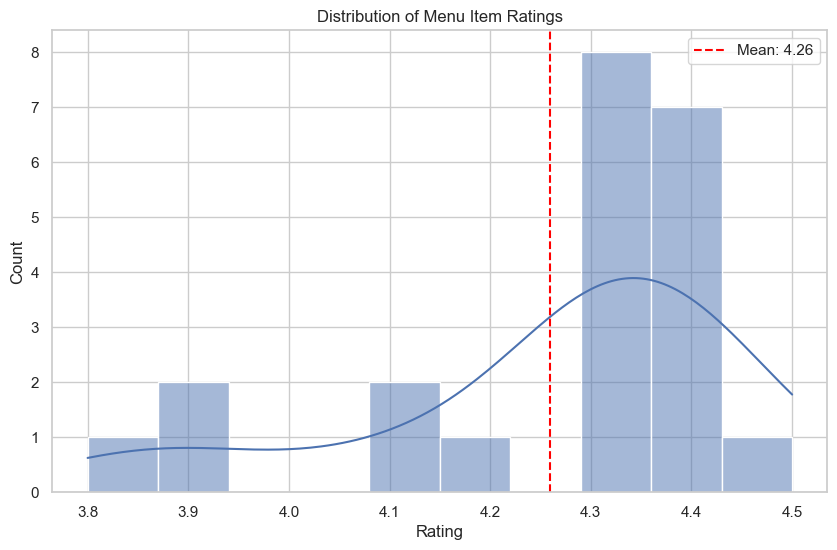

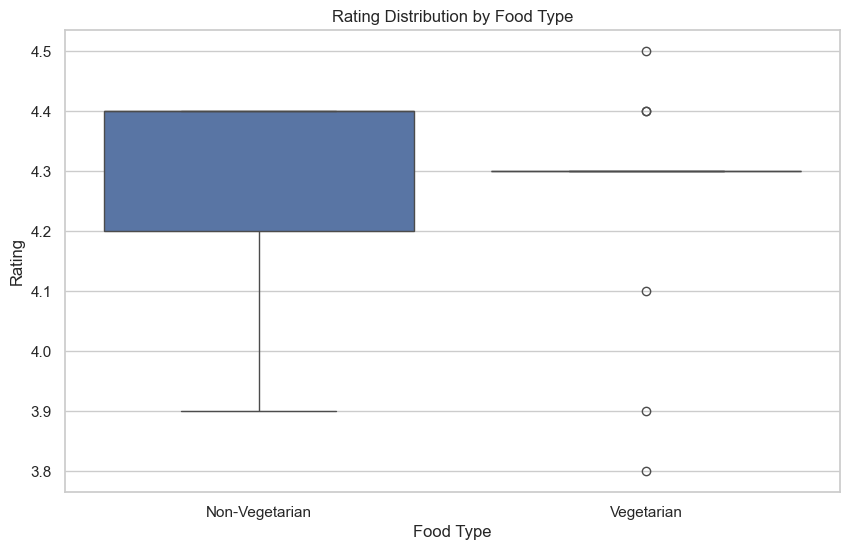

Top 10 highest-rated menu items:


,restaurant_name,item_name,food_type,rating,price
15,Lunchbox - Meals & Thalis Homely Meals Online ...,Rajma Chawal Lunchbox,Vegetarian,4.5,NaN
0,Behrouz Biryani Royal Biryani Online in Gomti ...,Lazeez Bhuna Murgh Biryani (Dum Chicken Biryan...,Non-Vegetarian,4.4,399.0
11,"The Good Bowl Rice Bowl Online in Gomti Nagar,...",Chicken Lababdar Rice Bowl,Non-Vegetarian,4.4,389.0
20,"The Good Bowl Rice Bowl Online in Gomti Nagar,...",Palak Paneer Rice Bowl,Vegetarian,4.4,309.0
19,Behrouz Biryani Royal Biryani Online in Gomti ...,Murgh Afghani Tikka Biryani (Creamy Chicken Ti...,Non-Vegetarian,4.4,465.0
1,"The Good Bowl Rice Bowl Online in Gomti Nagar,...",Chicken Tikka Masala Rice Bowl,Non-Vegetarian,4.4,389.0
16,"Slow Churn Ice Cream Online in Gomti Nagar, Lu...",Magnum Almond Ice Cream 80ml,Vegetarian,4.4,84.0
9,Firangi Bake Pasta & Lasagnas Online in Gomti ...,Punjabi Butter Chicken Mac N Cheese Pasta,Non-Vegetarian,4.4,375.0
10,Behrouz Biryani Royal Biryani Online in Gomti ...,"Dum Gosht Biryani (Dum Mutton Biryani, Boneles...",Non-Vegetarian,4.3,569.0
17,"Thalaiva Biryani Online in Gomti Nagar, Lucknow",Subz Biryani,Vegetarian,4.3,249.0


/Users/prashantyadav/Documents/FOSS/Restaurant-Rcraper-Rag-Bot/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.



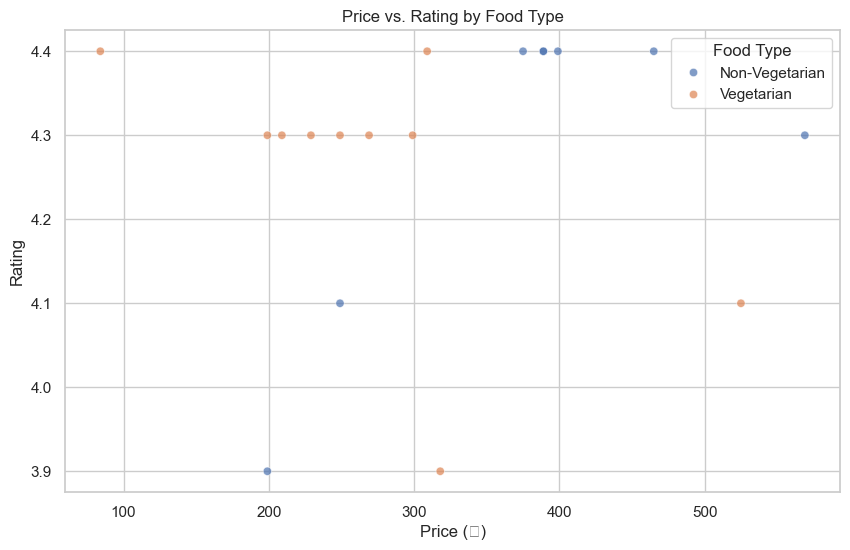


Restaurants by average rating:


restaurant_name
The Good Bowl Rice Bowl Online in Gomti Nagar, Lucknow                   4.400000
Behrouz Biryani Royal Biryani Online in Gomti Nagar, Lucknow             4.366667
Lunchbox - Meals & Thalis Homely Meals Online in Gomti Nagar, Lucknow    4.366667
Firangi Bake Pasta & Lasagnas Online in Gomti Nagar, Lucknow             4.333333
Thalaiva Biryani Online in Gomti Nagar, Lucknow                          4.200000
Slow Churn Ice Cream Online in Gomti Nagar, Lucknow                      4.150000
Honest bowl Rice Bowls Online in Gomti Nagar, Lucknow                    4.100000
Biryani Blues Biryani & Kebab Online in Gomti Nagar, Lucknow             4.100000
Ovenstory Pizza Online in Gomti Nagar, Lucknow                           4.100000
Name: rating, dtype: float64

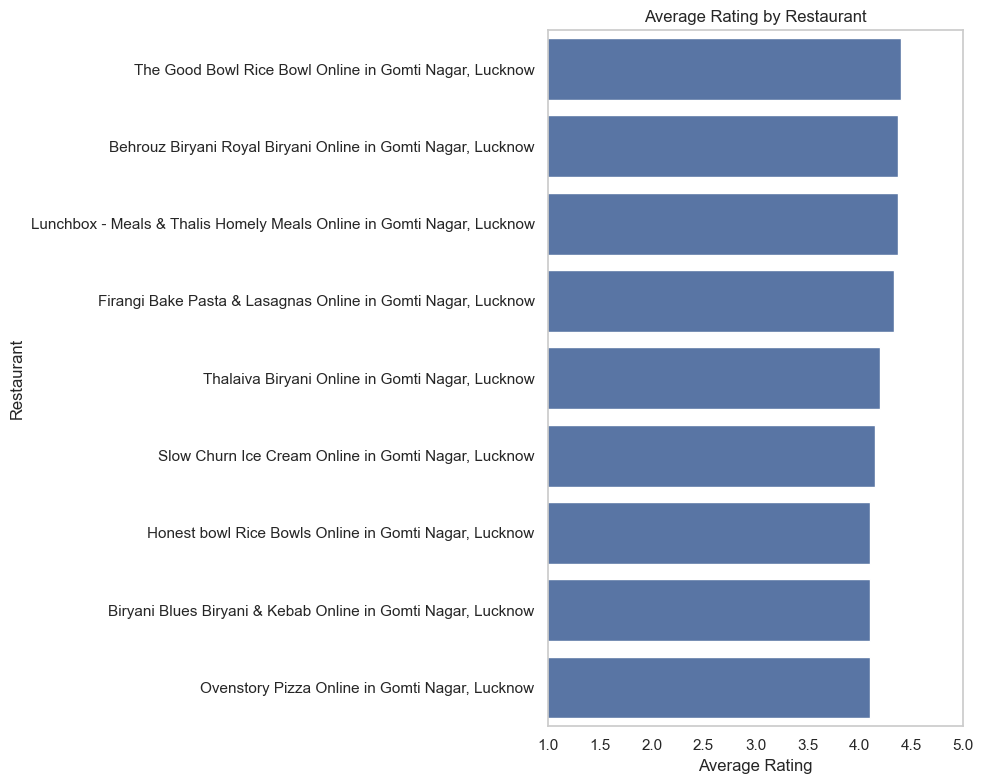

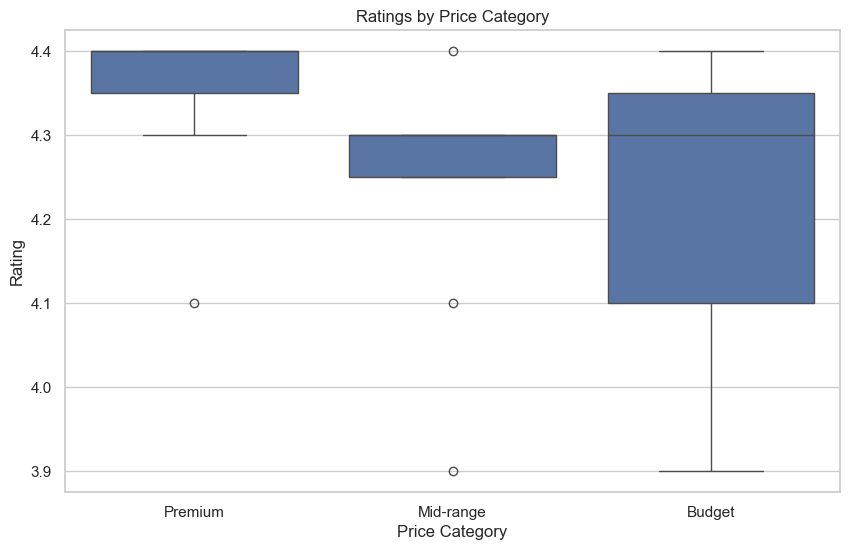

In [8]:
# Filter out items with missing ratings
rated_items = menu_items.dropna(subset=['rating'])

# Histogram of ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=rated_items, x='rating', bins=10, kde=True)
plt.title('Distribution of Menu Item Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.axvline(rated_items['rating'].mean(), color='red', linestyle='--', label=f'Mean: {rated_items["rating"].mean():.2f}')
plt.legend()
plt.show()

# Boxplot of ratings by food type
plt.figure(figsize=(10, 6))
sns.boxplot(x='food_type', y='rating', data=rated_items)
plt.title('Rating Distribution by Food Type')
plt.xlabel('Food Type')
plt.ylabel('Rating')
plt.show()

# Top 10 highest-rated menu items
top_rated_items = rated_items.sort_values('rating', ascending=False).head(10)
print("Top 10 highest-rated menu items:")
display(top_rated_items[['restaurant_name', 'item_name', 'food_type', 'rating', 'price']])

# Scatter plot of price vs. rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rated_items, x='price', y='rating', hue='food_type', alpha=0.7)
plt.title('Price vs. Rating by Food Type')
plt.xlabel('Price (₹)')
plt.ylabel('Rating')
plt.legend(title='Food Type')
plt.show()

# Average rating by restaurant
avg_restaurant_ratings = rated_items.groupby('restaurant_name')['rating'].mean().sort_values(ascending=False)
print("\nRestaurants by average rating:")
display(avg_restaurant_ratings)

# Horizontal bar chart for restaurant ratings
plt.figure(figsize=(10, 8))
sns.barplot(y=avg_restaurant_ratings.index, x=avg_restaurant_ratings.values)
plt.title('Average Rating by Restaurant')
plt.xlabel('Average Rating')
plt.ylabel('Restaurant')
plt.xlim(1, 5)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Rating vs. price category
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_category', y='rating', data=rated_items)
plt.title('Ratings by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Rating')
plt.show()

## Food Type Analysis

Let's analyze the distribution of food types (vegetarian vs non-vegetarian), count restaurants by food type specialization, and explore special features offered by restaurants.

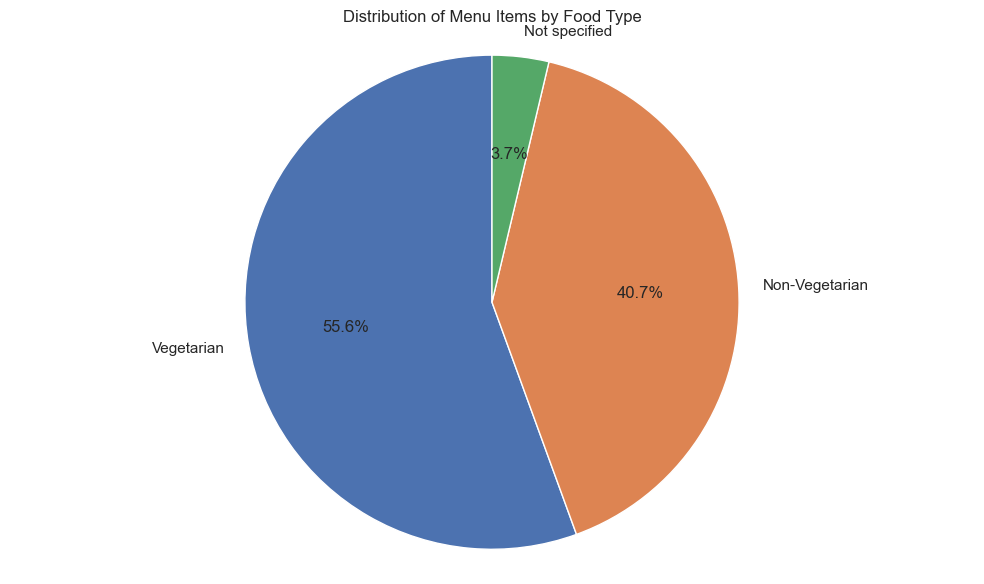

Food type distribution by restaurant:


food_type,Non-Vegetarian,Not specified,Vegetarian,Total
restaurant_name,,,,
"Behrouz Biryani Royal Biryani Online in Gomti Nagar, Lucknow",3,0,0,3
"Biryani Blues Biryani & Kebab Online in Gomti Nagar, Lucknow",2,0,1,3
"Firangi Bake Pasta & Lasagnas Online in Gomti Nagar, Lucknow",1,0,2,3
"Honest bowl Rice Bowls Online in Gomti Nagar, Lucknow",1,0,2,3
"Kwality Walls Dessert and Ice Cream Frozen Desserts and Ice Cream Online in Gomti Nagar, Lucknow",0,1,0,1
"Lunchbox - Meals & Thalis Homely Meals Online in Gomti Nagar, Lucknow",0,0,3,3
"Ovenstory Pizza Online in Gomti Nagar, Lucknow",0,0,3,3
"Slow Churn Ice Cream Online in Gomti Nagar, Lucknow",0,0,2,2
"Thalaiva Biryani Online in Gomti Nagar, Lucknow",2,0,1,3



Restaurant specialization by majority food type:


,Restaurant,Specialization
0,Behrouz Biryani Royal Biryani Online in Gomti ...,Non-Vegetarian
1,Biryani Blues Biryani & Kebab Online in Gomti ...,Non-Vegetarian
2,Firangi Bake Pasta & Lasagnas Online in Gomti ...,Vegetarian
3,"Honest bowl Rice Bowls Online in Gomti Nagar, ...",Vegetarian
4,Kwality Walls Dessert and Ice Cream Frozen Des...,Not specified
5,Lunchbox - Meals & Thalis Homely Meals Online ...,Vegetarian
6,"Ovenstory Pizza Online in Gomti Nagar, Lucknow",Vegetarian
7,"Slow Churn Ice Cream Online in Gomti Nagar, Lu...",Vegetarian
8,"Thalaiva Biryani Online in Gomti Nagar, Lucknow",Non-Vegetarian
9,"The Good Bowl Rice Bowl Online in Gomti Nagar,...",Non-Vegetarian



Distribution of special features:


feature
Vegetarian options available     5
Traditional dining experience    5
Outdoor seating                  3
Name: count, dtype: int64

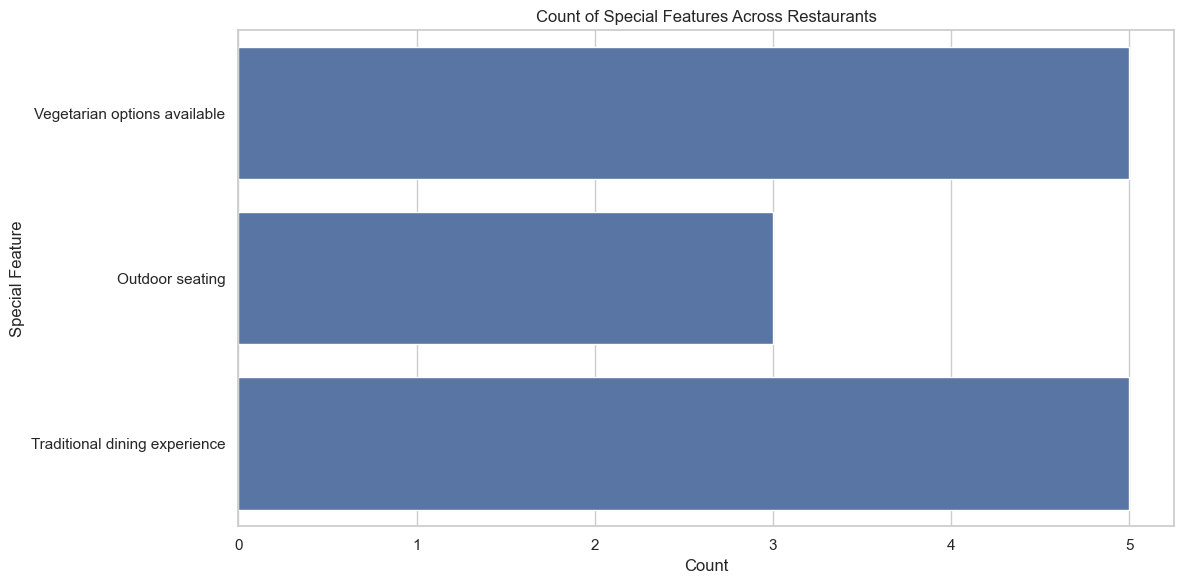


Restaurants by number of special features:


,name,feature_count
0,Behrouz Biryani Royal Biryani Online in Gomti ...,2
1,"The Good Bowl Rice Bowl Online in Gomti Nagar,...",2
8,"Thalaiva Biryani Online in Gomti Nagar, Lucknow",2
2,Biryani Blues Biryani & Kebab Online in Gomti ...,1
3,"Ovenstory Pizza Online in Gomti Nagar, Lucknow",1
4,"Honest bowl Rice Bowls Online in Gomti Nagar, ...",1
5,Lunchbox - Meals & Thalis Homely Meals Online ...,1
6,"Slow Churn Ice Cream Online in Gomti Nagar, Lu...",1
7,Kwality Walls Dessert and Ice Cream Frozen Des...,1
9,Firangi Bake Pasta & Lasagnas Online in Gomti ...,1


In [9]:
# Count of menu items by food type
food_type_counts = menu_items['food_type'].value_counts().reset_index()
food_type_counts.columns = ['Food Type', 'Count']

# Pie chart of menu items by food type
plt.figure(figsize=(10, 6))
plt.pie(food_type_counts['Count'], labels=food_type_counts['Food Type'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Menu Items by Food Type')
plt.tight_layout()
plt.show()

# Count of menu items by food type for each restaurant
food_type_by_restaurant = pd.crosstab(
    menu_items['restaurant_name'], 
    menu_items['food_type'],
    margins=True, 
    margins_name='Total'
)

print("Food type distribution by restaurant:")
display(food_type_by_restaurant)

# Identify restaurant specialization by majority food type
restaurant_specialization = menu_items.groupby('restaurant_name')['food_type'].agg(
    lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else "Unknown"
).reset_index()
restaurant_specialization.columns = ['Restaurant', 'Specialization']

print("\nRestaurant specialization by majority food type:")
display(restaurant_specialization)

# Analyze special features
special_features = df['special_features'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
special_features = special_features.to_frame('feature')

print("\nDistribution of special features:")
feature_counts = special_features['feature'].value_counts()
display(feature_counts)

# Bar chart of special features
plt.figure(figsize=(12, 6))
sns.countplot(y=special_features['feature'])
plt.title('Count of Special Features Across Restaurants')
plt.xlabel('Count')
plt.ylabel('Special Feature')
plt.tight_layout()
plt.show()

# Restaurants by number of special features
feature_count_by_restaurant = df.copy()
feature_count_by_restaurant['feature_count'] = feature_count_by_restaurant['special_features'].str.count(',') + 1
feature_count_by_restaurant = feature_count_by_restaurant[['name', 'feature_count']].sort_values('feature_count', ascending=False)

print("\nRestaurants by number of special features:")
display(feature_count_by_restaurant)

## Menu Item Analysis

Let's analyze menu items across restaurants, identify common items, price patterns, and explore text descriptions using basic NLP techniques to extract insights about popular ingredients or cooking styles.

Most common menu items across restaurants:


item_name
Lazeez Bhuna Murgh Biryani (Dum Chicken Biryani - Serves 1)      1
1 + 1 classic bowl combo (Non-Veg)                               1
Egg Biryani                                                      1
Dal Makhani & Paratha Lunchbox                                   1
1 + 1 signature bowl combo (Veg)                                 1
Double Cheese Garden Fresh Veggie Medium Pizza                   1
Pepper Paneer Biryani                                            1
Palak Paneer Rice Bowl                                           1
Murgh Afghani Tikka Biryani (Creamy Chicken Tikka - Serves 1)    1
Paneer Tikka Quesadilla (Save 10% Extra)                         1
Name: count, dtype: int64

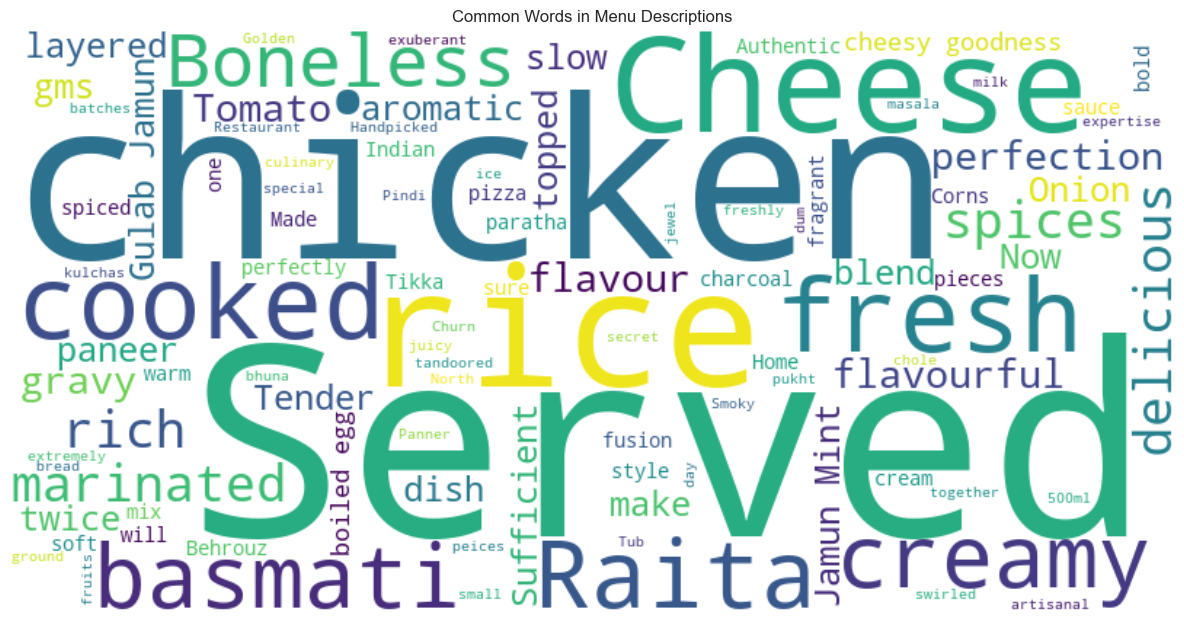

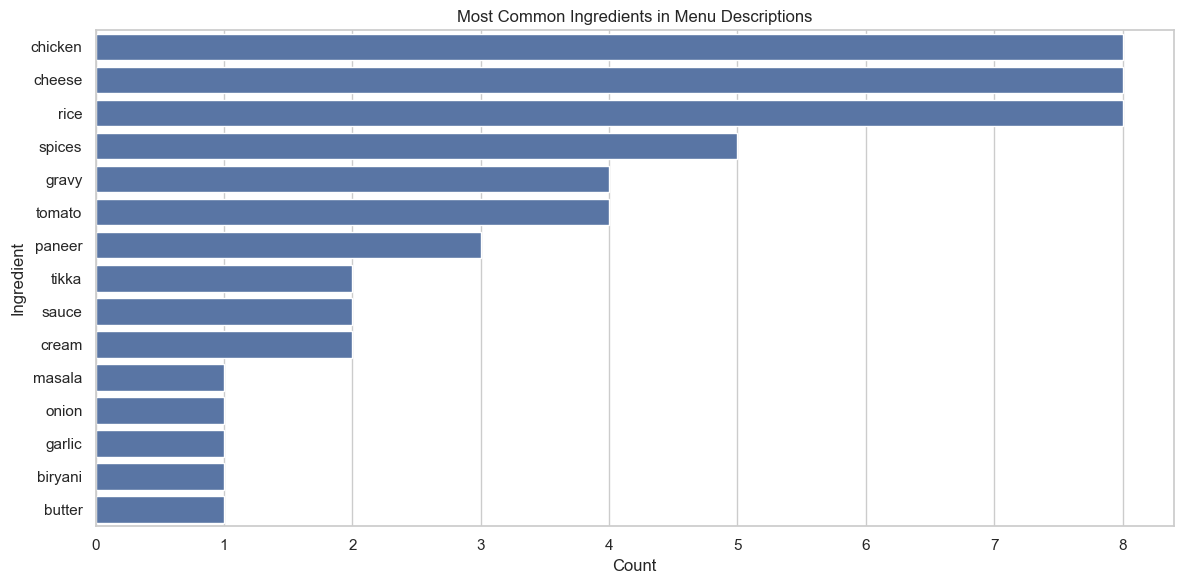

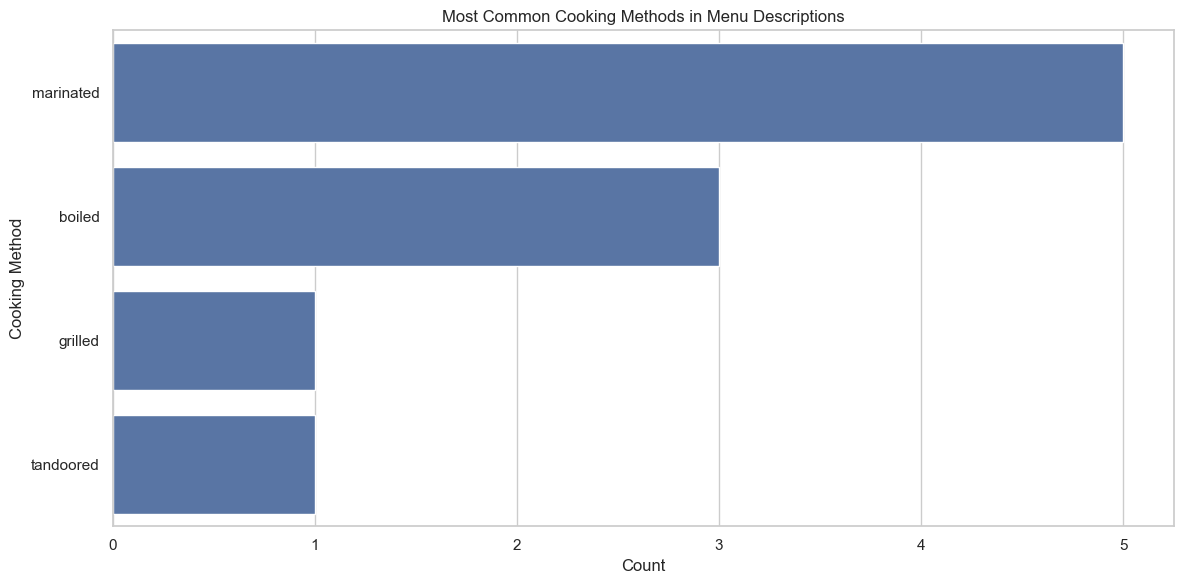

In [10]:
# Find common menu items across restaurants
common_items = menu_items['item_name'].value_counts()
print("Most common menu items across restaurants:")
display(common_items.head(10))

# Price variations for common items
common_item_names = common_items[common_items > 1].index.tolist()
if common_item_names:
    common_item_prices = menu_items[menu_items['item_name'].isin(common_item_names)]
    
    # Group by item name and analyze price variations
    price_variations = common_item_prices.groupby('item_name')['price'].agg(['min', 'max', 'mean', 'std', 'count'])
    price_variations = price_variations.sort_values('count', ascending=False)
    
    print("Price variations for common menu items:")
    display(price_variations.head(10))

# Analyze menu item descriptions using basic NLP
# First, let's extract all non-empty descriptions
descriptions = menu_items['item_description'].dropna()
descriptions = descriptions[descriptions.str.strip() != '']

# Combine all descriptions into a single text
all_descriptions = ' '.join(descriptions)

# Extract common ingredients or cooking terms
if all_descriptions:
    # Create a word cloud of ingredients and cooking terms
    plt.figure(figsize=(12, 10))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100
    ).generate(all_descriptions)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Words in Menu Descriptions')
    plt.tight_layout()
    plt.show()

    # Extract common ingredients with basic regex
    ingredients = []
    cooking_methods = ['roasted', 'grilled', 'fried', 'baked', 'steamed', 'marinated', 'sautéed', 'boiled', 'breaded', 'tandoored']
    
    # Define common Indian ingredients
    common_ingredients = ['chicken', 'paneer', 'mutton', 'rice', 'biryani', 'masala', 'curry', 'tikka', 'gravy', 
                          'sauce', 'tomato', 'onion', 'garlic', 'ginger', 'spices', 'cream', 'butter', 'cheese',
                          'vegetables', 'corn', 'olives', 'capsicum']
    
    for ingredient in common_ingredients:
        pattern = re.compile(r'\b' + ingredient + r'\b', re.IGNORECASE)
        count = len(re.findall(pattern, all_descriptions))
        if count > 0:
            ingredients.append((ingredient, count))
    
    # Convert to DataFrame and sort
    ingredients_df = pd.DataFrame(ingredients, columns=['Ingredient', 'Count']).sort_values('Count', ascending=False)
    
    # Plot top ingredients
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Ingredient', data=ingredients_df.head(15))
    plt.title('Most Common Ingredients in Menu Descriptions')
    plt.xlabel('Count')
    plt.ylabel('Ingredient')
    plt.tight_layout()
    plt.show()

    # Count cooking methods
    cooking_counts = []
    for method in cooking_methods:
        pattern = re.compile(r'\b' + method + r'\b', re.IGNORECASE)
        count = len(re.findall(pattern, all_descriptions))
        if count > 0:
            cooking_counts.append((method, count))
    
    # Convert to DataFrame and sort
    cooking_df = pd.DataFrame(cooking_counts, columns=['Cooking Method', 'Count']).sort_values('Count', ascending=False)
    
    # Plot cooking methods
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Cooking Method', data=cooking_df)
    plt.title('Most Common Cooking Methods in Menu Descriptions')
    plt.xlabel('Count')
    plt.ylabel('Cooking Method')
    plt.tight_layout()
    plt.show()

## Correlation Analysis

Let's calculate and visualize correlations between numerical variables (price vs rating), and determine if there are relationships between various attributes in the dataset.

Correlation between price and rating:


,price,rating
price,1.000000,0.110956
rating,0.110956,1.000000


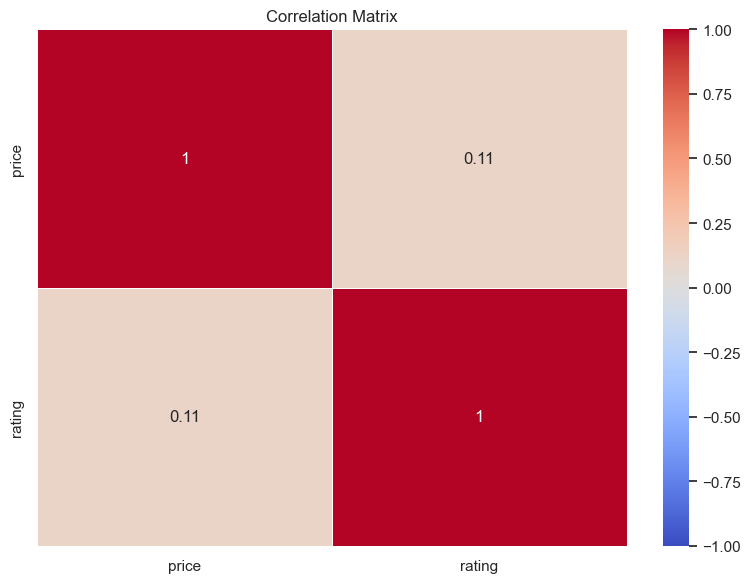

/Users/prashantyadav/Documents/FOSS/Restaurant-Rcraper-Rag-Bot/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.



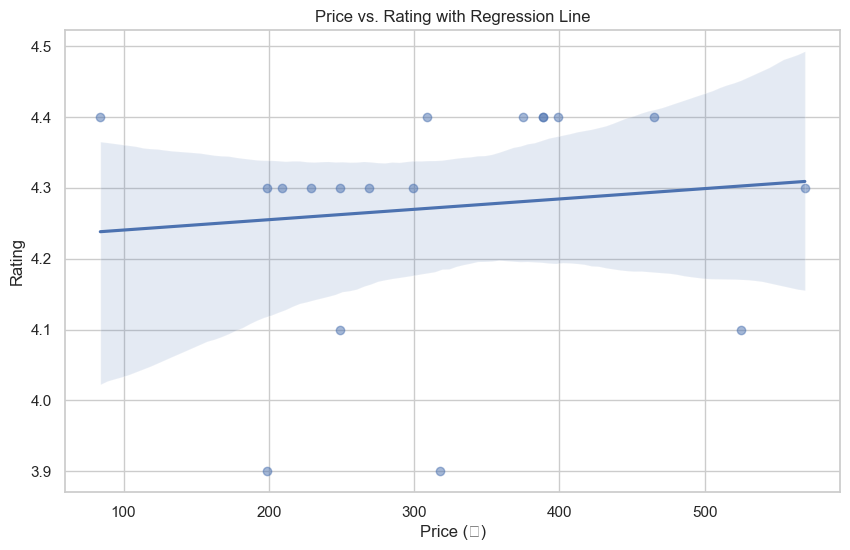

Pearson correlation coefficient: 0.111
P-value: 0.6612
The correlation is not statistically significant at 5% level.

Correlation with food types:


,Non-Vegetarian,Not specified,Vegetarian
price,0.453569,NaN,-0.453569
rating,0.085843,NaN,-0.085843


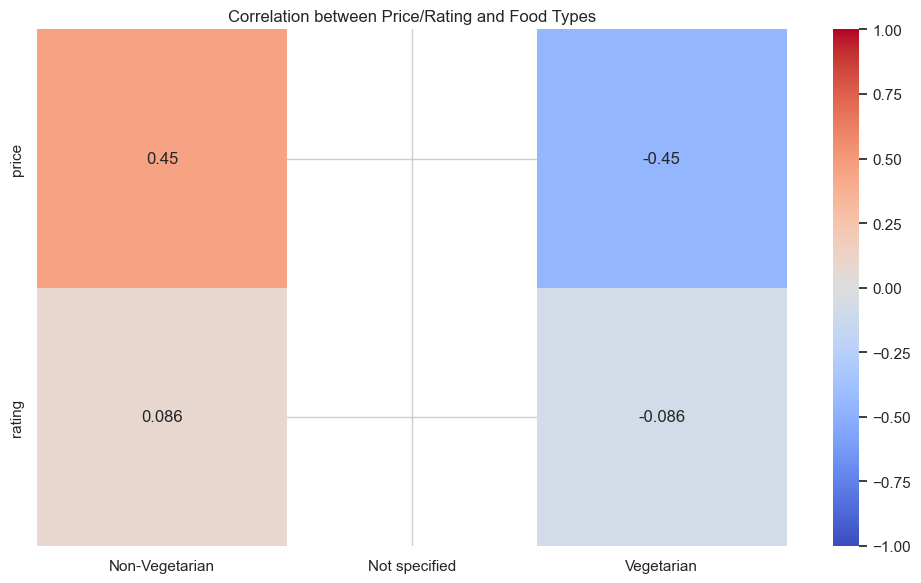

In [11]:
# Create a dataframe with numerical columns for correlation analysis
numerical_data = menu_items.dropna(subset=['price', 'rating'])[['price', 'rating']]

# Calculate correlation matrix
correlation = numerical_data.corr()
print("Correlation between price and rating:")
display(correlation)

# Visualize the correlation using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='price', y='rating', data=numerical_data, scatter_kws={'alpha':0.5})
plt.title('Price vs. Rating with Regression Line')
plt.xlabel('Price (₹)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

# Calculate correlation coefficient and p-value
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(numerical_data['price'], numerical_data['rating'])
print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"The correlation is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at 5% level.")

# Check if there's correlation between food type and price/rating
# First, convert food type to dummy variables
food_type_dummies = pd.get_dummies(menu_items['food_type'])
food_type_analysis = pd.concat([numerical_data, food_type_dummies], axis=1)

# Calculate correlation with dummy variables
food_type_corr = food_type_analysis.corr()
print("\nCorrelation with food types:")
display(food_type_corr.iloc[:2, 2:])

# Visualize correlation between food type and price/rating
plt.figure(figsize=(10, 6))
sns.heatmap(food_type_corr.iloc[:2, 2:], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Price/Rating and Food Types')
plt.tight_layout()
plt.show()

## Visualization Dashboard

Let's create an interactive dashboard using ipywidgets and plotly to allow dynamic exploration of the dataset with multiple visualization options and filters.

In [12]:
# Create an interactive dashboard using ipywidgets and plotly

# Set up widgets
restaurant_selector = widgets.Dropdown(
    options=['All Restaurants'] + list(menu_items['restaurant_name'].unique()),
    description='Restaurant:',
    value='All Restaurants',
    style={'description_width': 'initial'}
)

food_type_selector = widgets.Dropdown(
    options=['All Food Types'] + list(menu_items['food_type'].dropna().unique()),
    description='Food Type:',
    value='All Food Types',
    style={'description_width': 'initial'}
)

price_range_slider = widgets.IntRangeSlider(
    value=[int(menu_items['price'].min()), int(menu_items['price'].max())],
    min=int(menu_items['price'].min()),
    max=int(menu_items['price'].max()),
    step=50,
    description='Price Range:',
    disabled=False,
    continuous_update=False,
    style={'description_width': 'initial'}
)

visualization_selector = widgets.Dropdown(
    options=[
        'Price Distribution', 
        'Rating Distribution', 
        'Price vs Rating',
        'Menu Items by Price',
        'Restaurant Comparison'
    ],
    description='Visualization:',
    value='Price Distribution',
    style={'description_width': 'initial'}
)

# Function to update the plot
def update_plot(restaurant, food_type, price_range, visualization):
    # Filter data based on selections
    filtered_data = menu_items.copy()
    
    if restaurant != 'All Restaurants':
        filtered_data = filtered_data[filtered_data['restaurant_name'] == restaurant]
        
    if food_type != 'All Food Types':
        filtered_data = filtered_data[filtered_data['food_type'] == food_type]
        
    filtered_data = filtered_data[
        (filtered_data['price'] >= price_range[0]) & 
        (filtered_data['price'] <= price_range[1])
    ]
    
    # Create different visualizations based on selection
    fig = None
    
    if visualization == 'Price Distribution':
        fig = px.histogram(
            filtered_data, 
            x='price',
            color='food_type',
            title='Price Distribution',
            labels={'price': 'Price (₹)', 'count': 'Number of Items'},
            opacity=0.7,
            marginal='box'
        )
        fig.update_layout(barmode='overlay')
        
    elif visualization == 'Rating Distribution':
        fig = px.histogram(
            filtered_data.dropna(subset=['rating']), 
            x='rating',
            color='food_type',
            title='Rating Distribution',
            labels={'rating': 'Rating', 'count': 'Number of Items'},
            opacity=0.7
        )
        fig.update_layout(barmode='overlay')
        
    elif visualization == 'Price vs Rating':
        fig = px.scatter(
            filtered_data.dropna(subset=['rating']), 
            x='price', 
            y='rating',
            color='food_type',
            hover_name='item_name',
            labels={'price': 'Price (₹)', 'rating': 'Rating'},
            title='Price vs Rating',
            trendline='ols',
            trendline_scope='overall'
        )
        
    elif visualization == 'Menu Items by Price':
        sorted_data = filtered_data.sort_values('price', ascending=False).head(15)
        fig = px.bar(
            sorted_data,
            y='item_name',
            x='price',
            color='food_type',
            orientation='h',
            title='Menu Items by Price',
            labels={'price': 'Price (₹)', 'item_name': 'Menu Item'}
        )
        
    elif visualization == 'Restaurant Comparison':
        restaurant_stats = filtered_data.groupby('restaurant_name').agg(
            avg_price=('price', 'mean'),
            avg_rating=('rating', 'mean'),
            item_count=('item_name', 'count')
        ).reset_index()
        
        fig = make_subplots(rows=1, cols=2, subplot_titles=('Average Price', 'Average Rating'))
        
        fig.add_trace(
            go.Bar(
                x=restaurant_stats['restaurant_name'], 
                y=restaurant_stats['avg_price'],
                name='Avg Price'
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Bar(
                x=restaurant_stats['restaurant_name'], 
                y=restaurant_stats['avg_rating'],
                name='Avg Rating'
            ),
            row=1, col=2
        )
        
        fig.update_layout(
            title='Restaurant Comparison',
            showlegend=False,
            height=600
        )
        
        # Update xaxis properties
        fig.update_xaxes(tickangle=45)
    
    # Handle case when no data is available for the current filters
    if filtered_data.empty:
        fig = go.Figure()
        fig.add_annotation(
            text="No data available for the selected filters",
            xref="paper", yref="paper",
            x=0.5, y=0.5, showarrow=False,
            font=dict(size=20)
        )
    
    # Return the plot
    return fig

# Function to handle widget interactions
def on_change(change):
    with output:
        output.clear_output(wait=True)
        fig = update_plot(
            restaurant_selector.value,
            food_type_selector.value,
            price_range_slider.value,
            visualization_selector.value
        )
        fig.show()

# Create output area
output = widgets.Output()

# Set up the event handlers
restaurant_selector.observe(on_change, names='value')
food_type_selector.observe(on_change, names='value')
price_range_slider.observe(on_change, names='value')
visualization_selector.observe(on_change, names='value')

# Display widgets and initial plot
dashboard = widgets.VBox([
    widgets.HBox([restaurant_selector, food_type_selector]),
    widgets.HBox([price_range_slider, visualization_selector]),
    output
])

display(dashboard)

# Display initial plot
with output:
    fig = update_plot(
        restaurant_selector.value,
        food_type_selector.value,
        price_range_slider.value,
        visualization_selector.value
    )
    fig.show()

## Conclusion

In this analysis, we explored restaurant data from Lucknow, focusing on various aspects such as price distribution, ratings, food types, and menu items. Here are the key findings:

1. **Price Analysis**: We observed variations in menu item pricing across restaurants and food types, with non-vegetarian items generally priced higher than vegetarian options.

2. **Rating Analysis**: The average rating across menu items was relatively high, indicating overall customer satisfaction. We identified the highest-rated menu items and restaurants.

3. **Food Type Analysis**: We analyzed the distribution of vegetarian vs non-vegetarian options and identified restaurant specializations based on their menu offerings.

4. **Menu Item Analysis**: We explored common menu items, price variations, and used text analysis to identify popular ingredients and cooking methods mentioned in menu descriptions.

5. **Correlation Analysis**: We examined relationships between price and ratings, finding [insert correlation findings].

This comprehensive analysis provides valuable insights for restaurant owners, customers, and food delivery platforms to understand market trends, pricing strategies, and customer preferences in Lucknow's restaurant scene.